# Análisis de las zonas alcanzables por el robot
Plate
Let  be the set formed by the points in  occupied by the plate. As an example of plate, we will select an arbitrary non convex shape. The plate bounding box is  long and  wide.

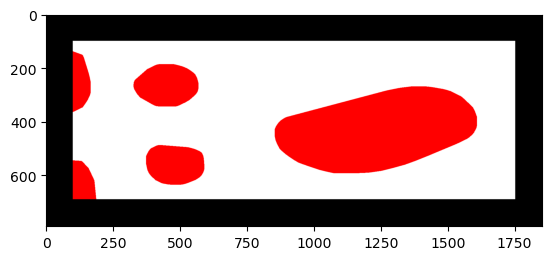

(791, 1854)
(791, 1854)


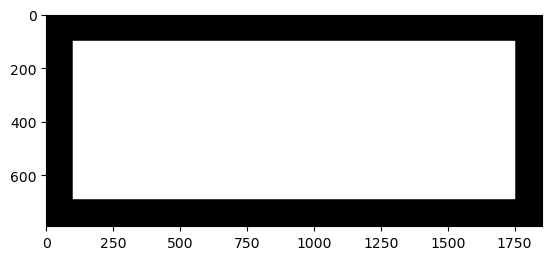

In [1]:
import cv2
import numpy as np
from skimage.morphology import convex_hull_image
import matplotlib.pyplot as plt
import WorkingZones as wz

# Load shape
P = cv2.imread("./images/panorama_border.png", cv2.IMREAD_GRAYSCALE)


# Perform convex hull operation
P = convex_hull_image(P)

# Display the resulting image or perform further operations
zonesName = "./images/panorama_hulls_filled.png"
image = cv2.imread(zonesName)
plt.imshow(image, cmap='gray')
plt.axis('on')
plt.show()    

print(P.shape)

# Define bounding box dimensions (1 pixel = 1 cm)
L_P = 1654
W_P = 591
bs = 100


# Resize the plate
P = wz.resizePlate(P, W_P, L_P, bs)
print(P.shape)
# Display the robot footprint
plt.imshow(P, cmap='gray')
plt.axis('on')
plt.show()

# Find the edge boundaries
contours, _ = cv2.findContours(P, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
Pedge = contours[0]

# Display the image with the edge boundaries
#plt.imshow(P, cmap='gray')
#plt.plot(Pedge[:, :, 0], Pedge[:, :, 1], 'r--', linewidth=2)
#plt.show()


# Robot
Let  be the set formed by the points in  inside the robot footprint. This footprint is defined by the projection on the floor of all the robot parts that must be kept within the plate during robot operation. As an example, we may consider that the robot footprint is a rectangle of length  and width . The centre of the robot lies at the footprint centre.

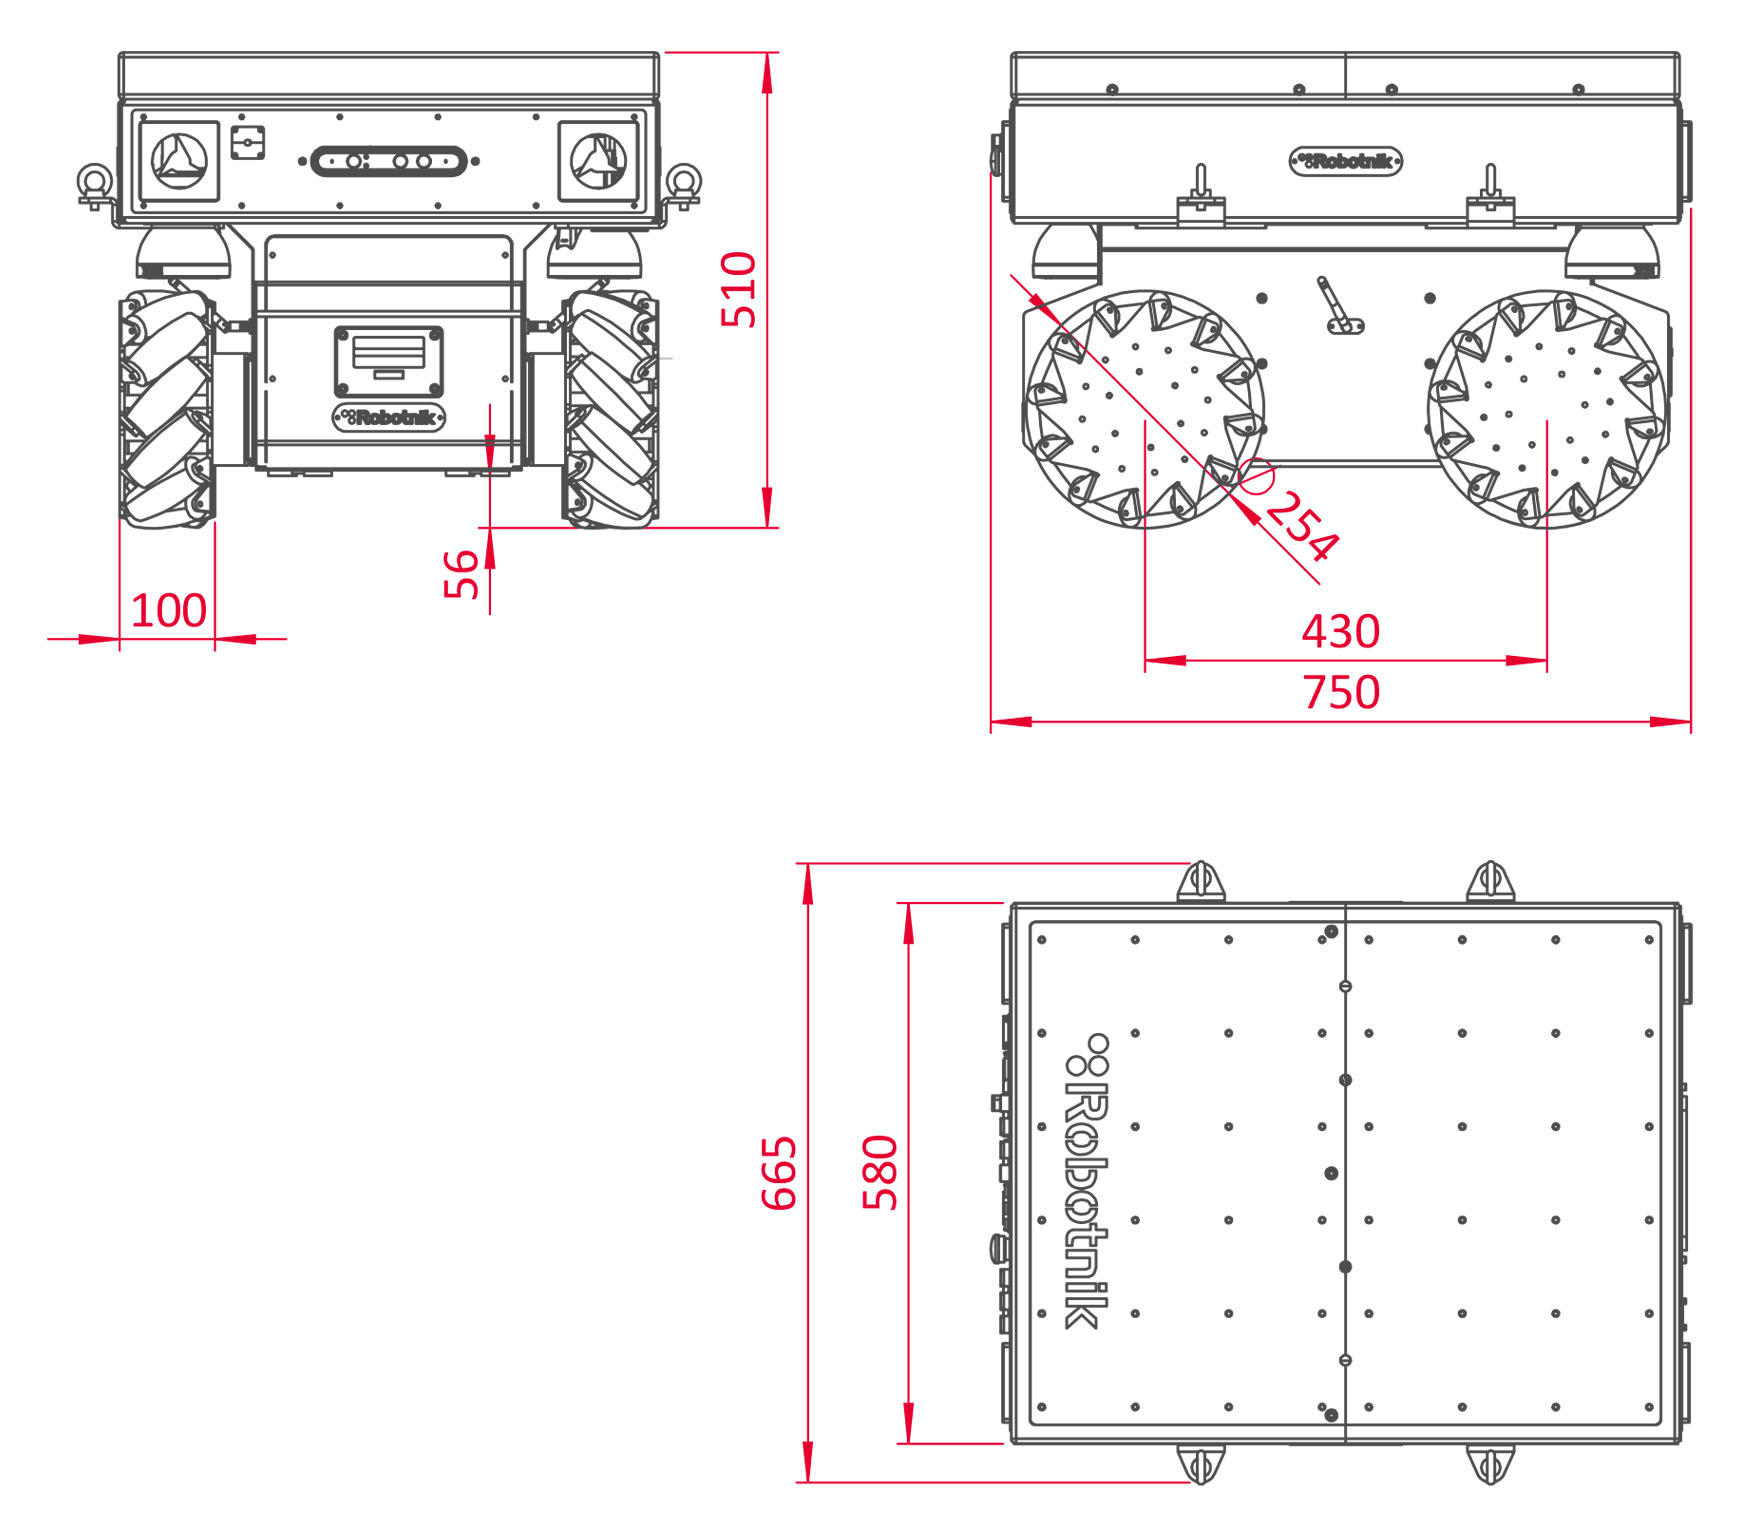


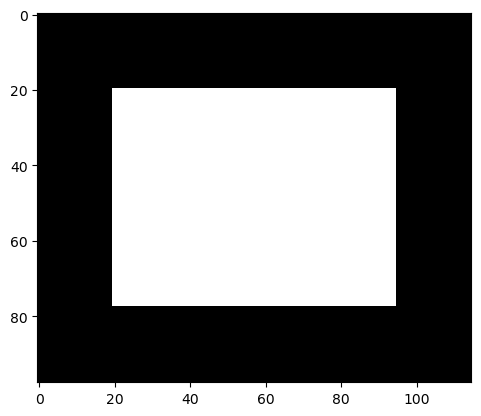

In [2]:
# Define robot size
L_R = 75   #75 # 1 pixel = 1 cm
W_R = 58    #58

# Define robot footprint
R_rct = np.ones((W_R, L_R), dtype=bool)

# Border size
border_size = 20

# Create a new black image with the border size added
new_image = np.zeros((W_R + 2*border_size, L_R + 2*border_size), dtype=np.uint8)

# Add the original image to the center of the new image
new_image[border_size:border_size+W_R, border_size:border_size+L_R] = R_rct

# Display the robot footprint
plt.imshow(new_image, cmap='gray')
plt.axis('on')
plt.show()

# Tool / Sensor
Let  be the set formed by the points in  inside the tool/sensor footprint. This footprint is defined by the intersection with the plate plane of the sensor field of view. In this example, we will consider a laser triangulation sensor, so the footprint will be a line of a given length () and width (). The center of the tool has an offset with respect to the robot centre , and form a constant angle with respect to the robot X axis .

t_x:  58.0
t_y:  34.0


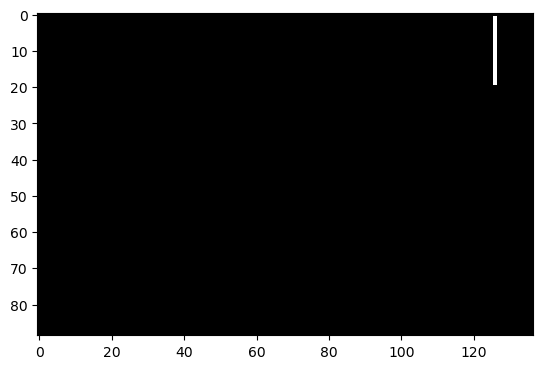

In [3]:
# Define sensor footprint size and offset
L_T = 20  # 1 pixel = 1 cm
W_T = 10
alpha_T = 90  # In degrees
t_x = np.ceil(L_R/2) + L_T
t_y = np.ceil(W_R/2) + W_T/2
print("t_x: ", t_x)
print("t_y: ", t_y)

T_roff = wz.toolFootprint(t_y, t_x, L_T, alpha_T)

plt.imshow(T_roff, cmap='gray')
plt.axis('on')
plt.show()


# Compute Safe Areas
Case 1: tool footprint may leave the plate
Compute the area travelled by the sensor for a given robot orientation, when the robot can not move outside the plate and the tool can.

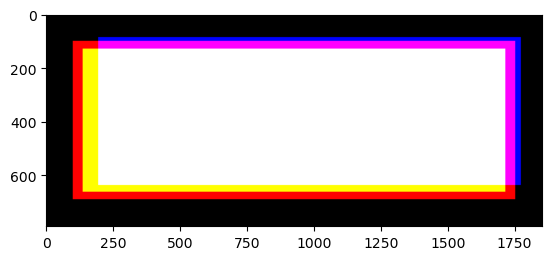

In [4]:
# Call the safeAreaRobot function
A, A_0 = wz.safeAreaRobot(P, R_rct, T_roff)

# Concatenate the arrays along the third dimension
combined = np.dstack((P, A_0, A))
# Convert the combined array to uint8 data type
combined = combined.astype(np.uint8)
# Scale the values by 255
scaled = combined * 255
# Display the image using Matplotlib
plt.imshow(scaled)
plt.show()


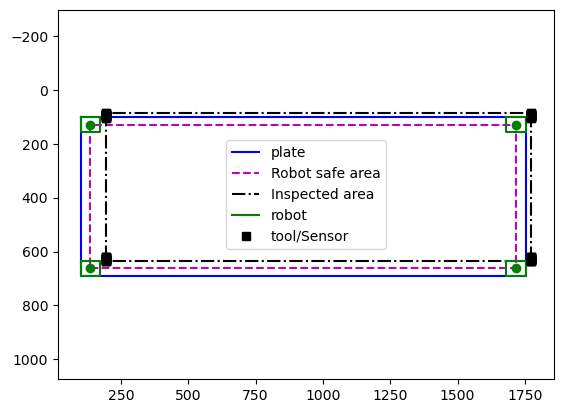

done


In [5]:
wz.drawSchematic(P, A_0, A, R_rct, T_roff)


The "Blue" area is the inspected zone that lies outside the plate. The "Yellow+White" area is area travelled by the robot. The "White+Magenta+Blue" area is the inspected area. The "Red+Yellow" area is the part of the plate that has not been inspected.

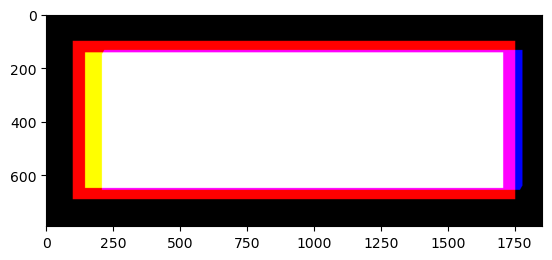

In [6]:
# robot orientation in degrees
alpha_R = -30
Rfp, Tfp, Rfpb0 = wz.rotateRobot(R_rct, T_roff, alpha_R)
A, A_0 = wz.safeAreaRobot(P, Rfp, Tfp)

# Concatenate the arrays along the third dimension
combined = np.dstack((P, A_0, A))
# Convert the combined array to uint8 data type
combined = combined.astype(np.uint8)
# Scale the values by 255
scaled = combined * 255
# Display the image using Matplotlib
plt.imshow(scaled)
plt.show()



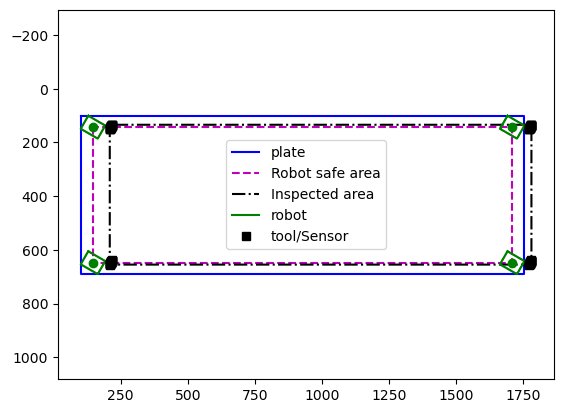

done


In [7]:
wz.drawSchematic(P, A_0, A, Rfp, Tfp, Rfpb0)

# Case 2: Tool footprint must stay within the plate
In this case, the robot footprint will be the union of the robot itself and the tool/sensor footprint. There may be a mixed situation: part of the sensor footprint must lay within the plate (for example the sensor body) and part of the sensor footprint may leave the plate (the field of view)

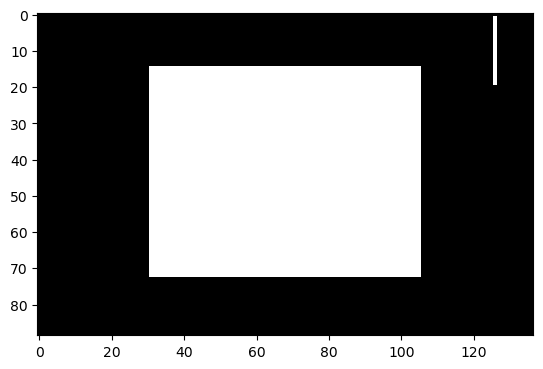

In [8]:
brakeDistance = 20
robotPose = -30
RT_fp = wz.strelUnion(R_rct, T_roff)

plt.imshow(RT_fp, cmap='gray')
plt.axis('on')
plt.show()

RTfp, Tfp, RTb0fp = wz.rotateRobotTool(RT_fp, T_roff, robotPose, brakeDistance)
A, A_0 = wz.safeAreaRobot(P, RTfp, Tfp)


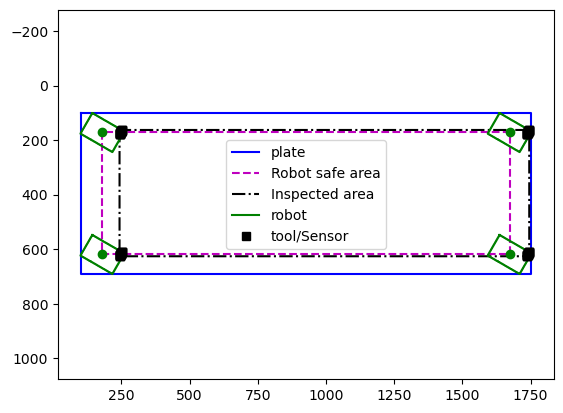

done


In [9]:
wz.drawSchematic(P, A_0, A, RTfp, Tfp, RTb0fp)

# Algorithm
1. Discretize the possible orientations. Each orientation will correspond to the main scanning direction for a boustrophedon trajectory

In [10]:

angStep = 45  # angular steps in degrees
angPose = np.arange(0, 360, angStep)  # possible angular values


2.    Define the maximum braking distance. This is the distance needed to achieve inspection speed or to stop.

In [11]:
brakeDistance = 60
robotPose = -30

3.    Define which part of the robot must be always inside the plate

In [12]:
RT_fp = wz.strelUnion(R_rct, T_roff)
size_P = np.array(P.shape)
length_angPose = len(angPose)


Create a data structure to store the inspected area and allowed robot positions for each possible orientation. In this case, it will be a 3D array. The first and second dimensions represent a position (Y axis is aligned with rows and X axis is aligned with columns). The third dimension represent a posible robot pose.

In [13]:

I_2 = np.zeros(np.concatenate((size_P, [length_angPose])), dtype=np.uint8)
I_20 = np.zeros(np.concatenate((size_P, [length_angPose])), dtype=np.uint8)


4.    For each posible pose compute
-    The footprints corresponding to current pose and allowed breaking distance
-    Erode the plate using robot footprint as structuring element. We use the helper function paddedErosion. This function pads with background values the plate before appling the erosion. Once the padded plate has been eroded, the padding is removed. This is to avoid the side effect caused by the function "imerode", that considers the points outside the image as foreground pixels.

The result is portion of the plate that can be occupied safely by the robot with this pose.
-    Compute the portion of the plate that can be inspected safely for this robot pose.

In [14]:

for k in range(len(angPose)):
    RTfp, Tfp, RTfpb0 = wz.rotateRobotTool(R_rct, T_roff, angPose[k], brakeDistance)
    A, A_0 = wz.safeAreaRobot(P, RTfp, Tfp)
    I_2[:, :, k] = A
    I_20[:, :, k] = A_0


Compute which plate region can be inspected (is reachable at least with one robot pose). It is the union of the areas inspected for any allowed robot pose.

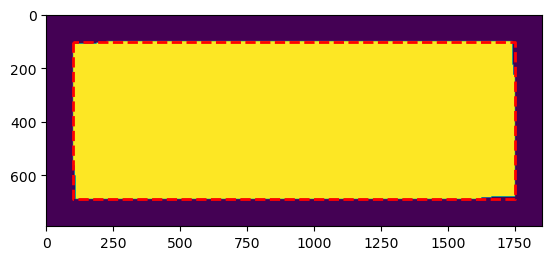

In [15]:
I = np.any(I_2, axis=2)
I = I.astype(np.uint8)*255
plt.imshow(I)
data = Pedge
x = data[:, 0, 0]
y = data[:, 0, 1]
x = np.append(x, x[0])
y = np.append(y, y[0])
plt.plot(x, y, 'r--', linewidth=2)
plt.show()

Compute which parts of the plate can not be inspected under this conditions (allowed robot poses, robot and tool/sensor size, and  braking distance).

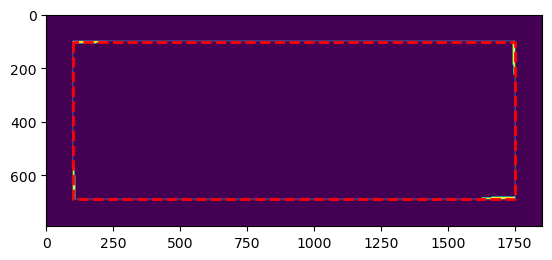

In [16]:
NI = P & (~I)
plt.imshow(NI)
plt.plot(x, y, 'r--', linewidth=2)
plt.show()

# Pose selection to inspect a plate region
The overall objective is to select wich orientations are needed to carry out a full inspection of a plate region while ensuring all safety constraints.
We start by selecting a region within the plate

In [17]:
zoneNum = 0
objZone = wz.AnalysisRegion(zonesName, zoneNum)
print(objZone.shape)


(791, 1854)


# Set covering heuristic:
We apply a greedy algorithm to solve the problem of selecting the mininum set of orientations to cover the whole area. At each step in the algorithm, we search for the point that is covered with the least number of possible orientations. In case of more than one option, we select the one which cover a bigger area.

angPose [  0  45  90 135 180 225 270 315]


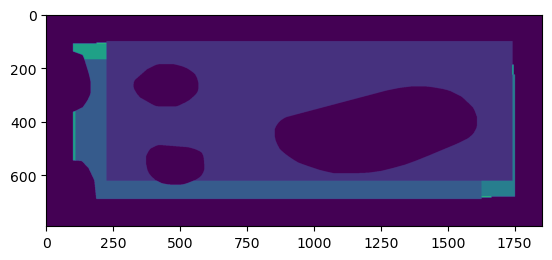

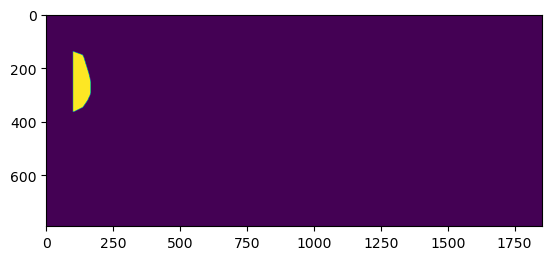

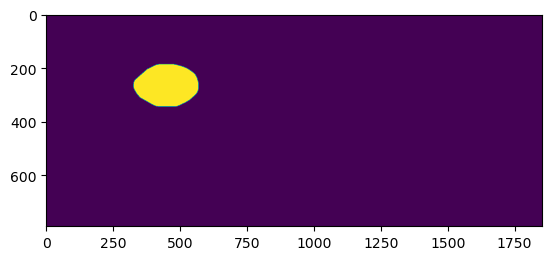

[0]


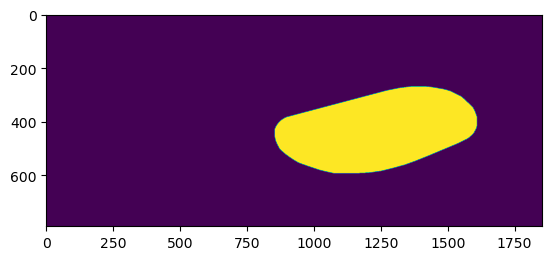

[0]


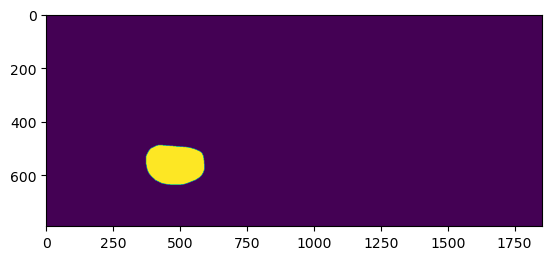

[4]


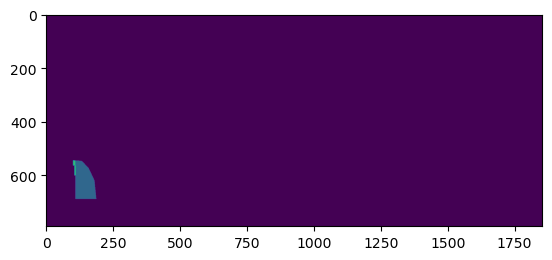

[4, 2, 3]


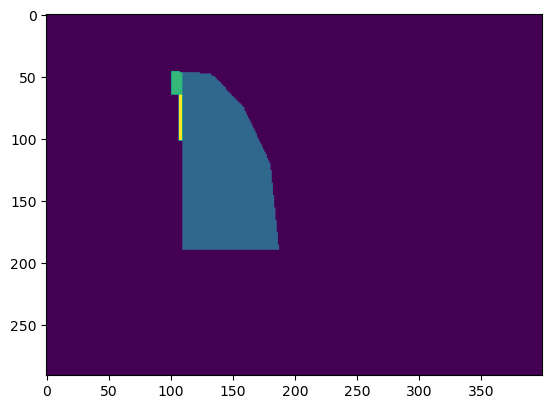

[4, 2, 3]


In [18]:

print("angPose", angPose)

orientation_array =[]
image_arry = []


zoneNum = 0 
objZone = wz.AnalysisRegion(zonesName, zoneNum)

indexSequence, sectionSequence, nonInspectZones, test = wz.solveSetCovering(objZone, I_2, 0)
plt.imshow(sectionSequence)
plt.show()




zoneNum = 1
objZone = wz.AnalysisRegion(zonesName, zoneNum)

indexSequence, sectionSequence, nonInspectZones, test = wz.solveSetCovering(objZone, I_2, 0)
plt.imshow(sectionSequence)
plt.show()


zoneNum = 2
objZone = wz.AnalysisRegion(zonesName, zoneNum)
indexSequence, sectionSequence, nonInspectZones, test = wz.solveSetCovering(objZone, I_2, 0)
plt.imshow(sectionSequence)
plt.show()
print(indexSequence)



zoneNum = 3
objZone = wz.AnalysisRegion(zonesName, zoneNum)

indexSequence, sectionSequence, nonInspectZones, test = wz.solveSetCovering(objZone, I_2, 0)
plt.imshow(sectionSequence)
plt.show()
print(indexSequence)


zoneNum = 4
objZone = wz.AnalysisRegion(zonesName, zoneNum)

indexSequence, sectionSequence, nonInspectZones, test = wz.solveSetCovering(objZone, I_2, 0)
plt.imshow(sectionSequence)
plt.show()
print(indexSequence)

zoneNum = 5
objZone = wz.AnalysisRegion(zonesName, zoneNum)

indexSequence, sectionSequence, nonInspectZones, test = wz.solveSetCovering(objZone, I_2, 0)
plt.imshow(sectionSequence)
plt.show()
print(indexSequence)


plt.imshow(sectionSequence[500::,0:400])
plt.show()
print(indexSequence)


